In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import feature, io, color
from skimage import io

## Import data

In [2]:
# Honey bee as 0.0
# Bumble bee as 1.0

labels = pd.read_csv('dataset/labels.csv', index_col=0)
labels.head()

,genus
id,
520,1.0
3800,1.0
3289,1.0
2695,1.0
4922,1.0


In [3]:
def get_image(row_id, root='dataset/images/'):
    
    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = io.imread(file_path)
    
    return img

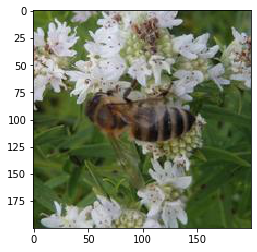

In [4]:
# Visualize Honey Bee
honey_bee_row = labels[labels.genus==0.0].index[5]
honey_bee = get_image(honey_bee_row)
plt.imshow(honey_bee)

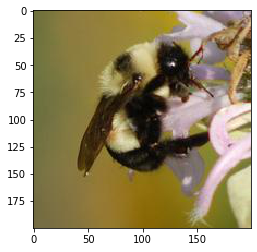

In [5]:
# Visualize Bumblee Bee

bumblee_bee_row = labels[labels.genus==1.0].index[5]
bumblee_bee = get_image(bumblee_bee_row)
plt.imshow(bumblee_bee)

## HOG Feature Extraction

In [6]:
images = []
X = []

for index, label in labels.iterrows():
    image = color.rgb2gray(get_image(index))
    images.append(image)
    X.append(feature.hog(image))

In [7]:
images = np.array(images)
images.shape

(3969, 200, 200)

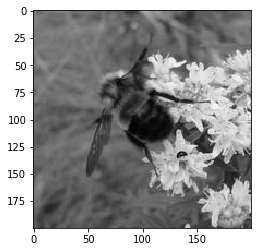

In [8]:
plt.imshow(images[0], cmap='gray')

In [9]:
labels

,genus
id,
520,1.0
3800,1.0
3289,1.0
2695,1.0
4922,1.0
...,...
4743,1.0
2787,1.0
3081,1.0


In [10]:
y = labels['genus'].values

## Train Test Split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=labels, test_size=0.25, random_state=27)

## Model Building

In [13]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

In [14]:
import pickle
from pathlib import Path

def pickle_exists(filename):
    file = Path('models2/' + filename + '.pkl')
    if file.is_file():
        return True
    return False

def save_model(model, filename):
    pickle.dump(model, open('models2/' + filename + '.pkl', 'wb'))
    
def load_model(filename):
    return pickle.load(open('models2/' + filename + '.pkl', 'rb'))

In [15]:
scorer = make_scorer(f1_score, average='macro')

def get_f1_score_of_model(model, x_test, y_test):
    y_predictions = model.predict(x_test)
    return f1_score(y_test, y_predictions, average='macro')
    
def grid_search_classifier(classifier, x_train, y_train, x_test, y_test, grid_params):
    clf = GridSearchCV(classifier(), grid_params, scoring=scorer)
    clf.fit(x_train, y_train)
    best_model = classifier(**clf.best_params_)
    best_model.fit(x_train, y_train)
    return best_model, get_f1_score_of_model(best_model, x_test, y_test)

In [16]:
random_state = [27]
verbose = [10]
classifiers = [
    (LogisticRegression, 
    {
        'C': (1,5,10),
        'max_iter': (100,500,1000),
        'verbose': verbose,
        'random_state': random_state,
    },
    'logistic_regression'),
    (DecisionTreeClassifier, 
     {
         'max_depth': (3,5,9),
         'min_samples_split': (2,6,10),
         'splitter': ('best', 'random'),
         'random_state': random_state
     },
    'decision_tree'),
    (SGDClassifier, 
     {
         'alpha': (0.0001,0.001,1),
         'max_iter': (100,500,1000),
         'learning_rate': ('optimal', 'adaptive'),
         'eta0': (0.01, 0.1, 0.5, 1.0),
         'verbose': verbose,
         'random_state': random_state
     },
    'sgd')
]

In [17]:
summary = []

for classifier, grid_params, filename in classifiers:
    if pickle_exists(filename):
        print('\nPickle already exists for ' + classifier.__name__ + '. Loading from file...')
        model = load_model(filename)
        score = get_f1_score_of_model(model, X_test, y_test)
    else:
        print('\nNo pickle found for ' + classifier.__name__ + '. Training model and saving to file...')
        model, score = grid_search_classifier(classifier, X_train, y_train, X_test, y_test, grid_params)
        save_model(model, filename)
    print(model)
    print('\nF1 Score for ' + classifier.__name__ + ': ')
    print(score)
    summary.append({'Classifier': classifier.__name__, 'F1 Score': score})
    
pd.DataFrame(summary)


Pickle already exists for LogisticRegression. Loading from file...
LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=27, solver='lbfgs', tol=0.0001, verbose=10,
                   warm_start=False)

F1 Score for LogisticRegression: 
0.5469521154516706

Pickle already exists for DecisionTreeClassifier. Loading from file...
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=27, splitter='random')

F1 Score for DecisionTreeClassifier: 
0.5193256231184082



,Classifier,F1 Score
0,LogisticRegression,0.546952
1,DecisionTreeClassifier,0.519326
2,SGDClassifier,0.545522


In [18]:
model = load_model('logistic_regression')

In [19]:
predicted_labels = model.predict(X_test)

In [20]:
len(predicted_labels)

993

In [21]:
X_test

[array([0.25212733, 0.        , 0.        , ..., 0.06915473, 0.00328291,
        0.01932472]),
 array([0.05017002, 0.0079802 , 0.00943294, ..., 0.13256965, 0.03303971,
        0.01519358]),
 array([0.05289893, 0.03220431, 0.08154465, ..., 0.00875774, 0.05758443,
        0.        ]),
 array([0.16202135, 0.        , 0.        , ..., 0.01958468, 0.01893981,
        0.        ]),
 array([0.39983797, 0.01367989, 0.01179793, ..., 0.21245355, 0.14994109,
        0.02087037]),
 array([0.27881143, 0.01973427, 0.02106814, ..., 0.08460168, 0.08754498,
        0.00328681]),
 array([0.21036601, 0.        , 0.05509304, ..., 0.07992011, 0.00514068,
        0.03201693]),
 array([0.24814123, 0.1070455 , 0.05118314, ..., 0.19065125, 0.06105937,
        0.01823646]),
 array([0.37521773, 0.07106742, 0.00353187, ..., 0.12079028, 0.00611282,
        0.04576603]),
 array([0.02024048, 0.01180197, 0.08843176, ..., 0.00177447, 0.00353611,
        0.00205342]),
 array([0.04950106, 0.01088651, 0.01717582, ..., 0

In [22]:
y_test

array([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
       0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.